In [1]:
import os
from os.path import exists
os.environ['OMP_NUM_THREADS'] = '1'
import glob
import sys
sys.path.append(os.path.join(os.getcwd(), *tuple(['..'])))
import argparse
import glob
import json
import pdb
import numpy as np
from skimage import draw
import matplotlib.pyplot as plt
import argparse
import pyfiglet
from skimage import measure
from tqdm import tqdm
from PIL import Image
import pyvips as Vips
from torchvision import transforms
import torchvision
import cv2
from shapely.geometry import Polygon
from shapely import box as shapely_box
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_recall_fscore_support

In [2]:
from models_pytorch_lightning.model_mrcnn_config import _default_mrcnn_config, build_default
from features import build_features
from models_pytorch_lightning.generalized_mask_rcnn_pl import LitMaskRCNN
from features import transforms as T
import torch

In [3]:
class_names = ["Cored","Diffuse","Coarse-Grained","CAA"]
test_config = dict(batch_size = 1,num_classes=4, device_id =0)
model_name= "/home/mahirwar/Desktop/Monika/npsad_data/vivek/runpod_mrcnn_models/yp2mf3i8_epoch=108-step=872.ckpt"
model_config = _default_mrcnn_config(num_classes=1 + test_config['num_classes']).config
model = LitMaskRCNN.load_from_checkpoint(model_name)

/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'rpn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['rpn'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'roi_heads' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['roi_heads'])`.
/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/lightning/pytorch/u

In [4]:
device = torch.device('cuda', test_config['device_id'])
model = model.to(device)
model.eval()

LitMaskRCNN(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256,

In [5]:
ID_MASK_SHAPE = (1024, 1024)

# Color Coding
lablel2id = {'Cored':'50', 'Diffuse':'100',
             'Coarse-Grained':'150', 'CAA': '200', 'Unknown':'0'}

DATASET_PATH = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data"

In [6]:
def save_img(img, file_name, tileX, tileY, label="mask"):
    im = Image.fromarray(img)

    base_name_with_ext = os.path.basename(file_name)

    # Remove the extension to get the folder name
    folder_name = os.path.splitext(base_name_with_ext)[0]

    folder_name = os.path.join(DATASET_PATH, folder_name)

    # Create the new folder only if it does not exist
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    # Mask Folder
    save_dir = os.path.join(folder_name, label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_name = file_name + "_" + str(tileX) + "x" + "_" + str(tileY) + "y" + "_" + label + ".png"

    save_name = os.path.join(save_dir, file_name)
    im.save(save_name)

In [7]:
def polygon2id(image_shape, mask, ids, coords_x, coords_y):
    vertex_row_coords, vertex_col_coords = coords_y, coords_x
    fill_row_coords, fill_col_coords = draw.polygon(
        vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = ids
    return mask

def polygon2mask1(image_shape, mask, color, coords_x, coords_y):
    """Compute a mask with labels having different colors
    from polygon.
    Parameters
    ----------
    image_shape : tuple of size 2.
        The shape of the mask.
    coords_x: X coordinates
    coords_y: Y coordinates
    mask : Mask with same size of the image (initially empty
    mask is given as input)
    Returns
    -------
    mask : 2-D ndarray of type 'bool'.
        The mask that corresponds to the input polygon.
    """

    vertex_row_coords, vertex_col_coords = coords_x, coords_y
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, image_shape)

    # Row and col are flipped
    mask[fill_col_coords, fill_row_coords] = color

    # mask[fill_row_coords, fill_col_coords] = color
    return mask



def get_vips_info(vips_img):
    # # Get bounds-x and bounds-y offset
    vfields = [f.split('.') for f in vips_img.get_fields()]
    vfields = [f for f in vfields if f[0] == 'openslide']
    vfields = dict([('.'.join(k[1:]), vips_img.get('.'.join(k))) for k in vfields])

    return vfields

In [8]:
def prepare_input(image):
    image_float_np = np.float32(image) / 255
    # define the torchvision image transforms
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        #transforms.Normalize([0.8883, 0.8769, 0.8431],[0.1425, 0.1589, 0.2029])
    ])
    input_tensor = transform(image)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_tensor = input_tensor.to(device)
    # Add a batch dimension
    input_tensor = input_tensor.unsqueeze(0)
    return input_tensor, image_float_np

In [9]:
def get_output(outputs, threshold ):
    i =0 
    pred_boxes =outputs[i]["boxes"].cpu().detach().numpy()
    pred_class_ids = outputs[i]["labels"].cpu().detach().numpy()
    pred_scores = outputs[i]["scores"].cpu().detach().numpy()
    pred_masks = outputs[i]["masks"][pred_scores>=threshold]
    pred_masks=pred_masks.squeeze(1).permute(2, 1, 0)
    pred_masks = pred_masks.cpu().detach().numpy()
    pred_boxes =pred_boxes[pred_scores>=threshold]
    pred_class_ids = pred_class_ids[pred_scores>=threshold]
    pred_scores = pred_scores[pred_scores>=threshold]
    return pred_scores,pred_class_ids,pred_masks,pred_boxes

In [10]:
def draw_boxes(boxes, image,gt_class, pred_class, rater_name):
    #for i, box in enumerate(boxes):
        #color = self.colors[labels[i]-1]
    cv2.rectangle(
        image,
        (int(boxes[0]), int(boxes[1])),
        (int(boxes[2]), int(boxes[3])),
        (0,0,0), 2
    )
    cv2.putText(image , "gt:"+gt_class+"_"+"pred:"+pred_class+"_"+rater_name, (int(boxes[0]), int(boxes[1])-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
    return image
    

In [11]:
def get_match(img, json_file_name, threshold =0.5):
    vips_img = Vips.Image.new_from_file(img, level=0)
    vinfo = get_vips_info(vips_img)

    # Get the corresponding json file
    json_file_name = os.path.basename(img).split(".mrxs")[0] + ".json"
    json_file_name = os.path.join(json_path, json_file_name)

    #if not exists(json_file_name):
    #    return

    with open(json_file_name) as f:
        data = json.load(f)
        

    actual_labels= []   
    raters = []
    pred_labels = []
    object_names = []
    k=0
    
    for tileId, ele in data.items():
        # print("****************", tileId)
        tileId = tileId.replace("[", "")
        tileId = tileId.replace("]", "")
        tileX = int(tileId.split(",")[0])
        tileY = int(tileId.split(",")[1])
        tileWidth = 1024
        tileHeight = 1024

        tileX = (tileX * tileWidth) + int(vinfo['bounds-x'])
        tileY = (tileY * tileHeight) + int(vinfo['bounds-y'])
            
        vips_img_crop = vips_img.crop(tileX, tileY, tileWidth, tileHeight)

        vips_img_crop = np.ndarray(buffer=vips_img_crop.write_to_memory(), dtype=np.uint8,
                                    shape=(vips_img_crop.height, vips_img_crop.width, vips_img_crop.bands))[..., :3]

        x1 = tileX - int(vinfo['bounds-x'])
        x2 = tileX + tileWidth - int(vinfo['bounds-x'])
        y1 = tileY - int(vinfo['bounds-y'])
        y2 = tileY + tileHeight - int(vinfo['bounds-y'])
        
        input_tensor, image_float_np = prepare_input(vips_img_crop)
        outputs = model.forward(input_tensor)
        #print(len(outputs))
        pred_scores,pred_class_ids,pred_masks,pred_boxes=get_output(outputs,0.75)

        pred_boxes_cnt =  [np.int32(np.array([[box[0],box[1]],[box[0],box[3]],[box[2],box[3]],[box[2],box[1]]])) for box in pred_boxes]
        #print("pred_boxes", pred_boxes_cnt)

        for region in ele:
            if 'label' in region.keys() and 'name' in region['label'].keys():
                x_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][0]
                y_bound = region["region_attributes"][0]['tiles'][0]["tileBounds"]['XY'][1]
                region_points = region["region_attributes"][0]["points"]
                region_points = [ [p[0]-x_bound, p[1]-y_bound] for p in region_points]
                #print(region["raterName"], len(region_points))
                mean_reg = np.mean(region_points, axis=0)
                for i, box in enumerate(pred_boxes_cnt):
                    if len(region_points)<4:
                        print(region_points)
                    if len(region_points)>=4:
                        polygon1 = Polygon(np.array(region_points,dtype=np.int32))
                        polygon2 = Polygon(box)
                            # Check for intersection
                        if polygon1.intersects(polygon2):
                            #matches=matches+1
                            #matched_list.append(region["object_name"])
                            actual_labels.append(region['label']['name'])
                            raters.append(region["raterName"])
                            pred_labels.append(class_names[pred_class_ids[i]-1])
                            if "object_name" in region.keys():
                                object_names.append(region["object_name"])
                            else:
                                object_names.append(None)
                        
                            if region['label']['name']!=class_names[pred_class_ids[i]-1]:
                                k=k+1
                                vips_img_crop1=vips_img_crop.copy()
                                #vips_img_crop1 = data_transforms["test"](vips_img_crop1)
                                #vips_img_crop1 = torch.permute(vips_img_crop1,(2,0,1))
                                vips_img_crop1 = np.ascontiguousarray(vips_img_crop1, dtype=np.uint8)
                                image = draw_boxes(pred_boxes[i], vips_img_crop1, region['label']['name'], class_names[pred_class_ids[i]-1], region["raterName"])
                                image1 = Image.fromarray(image)
                                image1.save("/home/mahirwar/Desktop/Monika/npsad_data/vivek/model_analysis/test-interrater/"+json_file_name.split("/")[-1]+str(tileId)+"_"+str(k)+".png")
    return actual_labels,raters,pred_labels,object_names


    #    break

In [12]:
#json_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/test_jsons_all"
json_path = "/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/test_json_harry_max_brittany_osama"
json_files = glob.glob(os.path.join(json_path,"*"))
json_files = [x.split("/")[-1] for x in json_files]
imgs = [os.path.join(DATASET_PATH,x.replace(".json",".mrxs")) for x in json_files]

In [13]:
imgs

['/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/420418_6_AmyB_1_ceren.mrxs',
 '/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/22640_1_AmyB_1_ceren.mrxs',
 '/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/30414_6_AmyB_1_ceren.mrxs',
 '/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/22650_7_AmyB_1_ceren.mrxs',
 '/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/25144_1_AmyB_1_ceren.mrxs',
 '/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Interrater_data/354049_6_AmyB_1_ceren.mrxs']

In [14]:
json_files

['420418_6_AmyB_1_ceren.json',
 '22640_1_AmyB_1_ceren.json',
 '30414_6_AmyB_1_ceren.json',
 '22650_7_AmyB_1_ceren.json',
 '25144_1_AmyB_1_ceren.json',
 '354049_6_AmyB_1_ceren.json']

In [15]:
actual_labels_all= []
raters_all = []
pred_labels_all = []
object_name_all= []
imgs_all = []

for img, json_file_name in zip(imgs,json_files):
    actual_labels,raters,pred_labels, object_names= get_match(img, json_file_name,0.73)
    actual_labels_all.extend(actual_labels)
    raters_all.extend(raters)
    pred_labels_all.extend(pred_labels)
    object_name_all.extend(object_names)
    imgs_all.extend([img.split("/")[-1]]*len(actual_labels))

In [16]:
df = pd.DataFrame({"pred_labels":pred_labels_all,"actual_label":actual_labels_all, "rater_name":raters_all,"object_names":object_name_all,"img_name":imgs_all})

In [17]:
df

,pred_labels,actual_label,rater_name,object_names,img_name
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs
2,Diffuse,Diffuse,Max,9:Diffuse,420418_6_AmyB_1_ceren.mrxs
3,Diffuse,Diffuse,Harry,30:Diffuse,420418_6_AmyB_1_ceren.mrxs
4,Diffuse,Diffuse,Harry,28:Diffuse,420418_6_AmyB_1_ceren.mrxs
...,...,...,...,...,...
455,Diffuse,Diffuse,Osama,38:Diffuse,354049_6_AmyB_1_ceren.mrxs
456,Diffuse,Coarse-Grained,Harry,33:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
457,Diffuse,Coarse-Grained,Harry,17:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
458,Diffuse,Diffuse,Harry,25:Diffuse,354049_6_AmyB_1_ceren.mrxs


In [18]:
df.groupby(["object_names"])["rater_name"].count()

object_names
01:Coarse-Grained    2
01:Cored             5
01:Diffuse           3
02:Coarse-Grained    2
02:Cored             3
                    ..
8:Cored              1
8:Diffuse            1
9:Coarse-Grained     2
9:Cored              1
9:Diffuse            2
Name: rater_name, Length: 173, dtype: int64

In [19]:
df[df["object_names"]!="None"]

,pred_labels,actual_label,rater_name,object_names,img_name
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs
2,Diffuse,Diffuse,Max,9:Diffuse,420418_6_AmyB_1_ceren.mrxs
3,Diffuse,Diffuse,Harry,30:Diffuse,420418_6_AmyB_1_ceren.mrxs
4,Diffuse,Diffuse,Harry,28:Diffuse,420418_6_AmyB_1_ceren.mrxs
...,...,...,...,...,...
455,Diffuse,Diffuse,Osama,38:Diffuse,354049_6_AmyB_1_ceren.mrxs
456,Diffuse,Coarse-Grained,Harry,33:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
457,Diffuse,Coarse-Grained,Harry,17:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
458,Diffuse,Diffuse,Harry,25:Diffuse,354049_6_AmyB_1_ceren.mrxs


In [20]:
df["rater_name"].unique()

array(['Max', 'Harry', 'Brittany', 'Osama'], dtype=object)

In [21]:
len(df)

460

In [25]:
#all_objects = pd.read_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Kappa_compute/max_brittany_objects_full.csv")

In [26]:
all_objects = pd.read_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/interrater_oct24/all_objects_full.csv") 

In [27]:
all_objects

,Unnamed: 0,Max_index,Max_class,Max_object_name,Harry_index,Harry_class,Harry_object_name,geojson_file,Brittany_index,Brittany_class,Brittany_object_name,Osama_index,Osama_class,Osama_object_name
0,0,0.0,Cored,2:Cored,7.0,Neuritic,04:Neuritic,22650_7_AmyB_1_ceren.mrxs.geojson,2.0,Diffuse,04:Diffuse,2.0,Diffuse,01:Diffuse
1,2,2.0,Coarse-Grained,1:Coarse-Grained,6.0,Neuritic,03:Neuritic,22650_7_AmyB_1_ceren.mrxs.geojson,1.0,Diffuse,02:Diffuse,1.0,Coarse-Grained,02:Coarse-Grained
2,3,3.0,Coarse-Grained,3:Coarse-Grained,10.0,Coarse-Grained,02:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,3.0,Diffuse,03:Diffuse,3.0,Coarse-Grained,03:Coarse-Grained
3,4,4.0,Coarse-Grained,8:Coarse-Grained,12.0,Coarse-Grained,22:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,4.0,Coarse-Grained,11:Coarse-Grained,4.0,Coarse-Grained,06:Coarse-Grained
4,5,5.0,Coarse-Grained,12:Coarse-Grained,15.0,Coarse-Grained,23:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,6.0,Coarse-Grained,12:Coarse-Grained,7.0,Coarse-Grained,05:Coarse-Grained
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,34,11.0,Diffuse,41:Diffuse,21.0,Coarse-Grained,81:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,2.0,Diffuse,25:Diffuse
355,37,29.0,Coarse-Grained,40:Coarse-Grained,21.0,Coarse-Grained,81:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,2.0,Diffuse,25:Diffuse
356,42,6.0,Diffuse,22:Diffuse,42.0,Diffuse,45:Diffuse,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,6.0,Diffuse,22:Diffuse
357,43,6.0,Diffuse,22:Diffuse,46.0,Diffuse,39:Diffuse,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,6.0,Diffuse,22:Diffuse


In [25]:
#all_objects_harry = pd.read_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/Kappa_compute/max_harry_objects_full.csv")

In [40]:
#max1  = all_objects[["main_rater_class","main_rater_object_name","rater1_class","rater1_object_name","geojson_file"]]

In [41]:
#len(max1)

In [103]:
#harry  = all_objects_harry[["main_rater_object_name","rater1_class","rater1_object_name","geojson_file"]]

In [43]:
#len(harry)

In [42]:
#harry.columns = ["main_rater_object_name","rater2_class","rater2_object_name","geojson_file"]

In [27]:
#all_raters_combined  = pd.merge(max1,harry,on=["main_rater_object_name","geojson_file"], how="left")

In [28]:
#all_raters_combined = all_raters_combined[all_raters_combined["main_rater_class"]!="None"]

In [34]:
#all_raters_combined["rater1_class"].unique()

In [35]:
#all_raters_combined["rater2_class"].unique()

In [36]:
#len(all_raters_combined)

In [37]:
#len(all_raters_combined[(all_raters_combined["main_rater_class"] == all_raters_combined["rater1_class"])])

In [38]:
#len(all_raters_combined[(all_raters_combined["main_rater_class"] == all_raters_combined["rater2_class"])])

In [40]:
#len(all_raters_combined[(all_raters_combined["rater1_class"] == all_raters_combined["rater2_class"]) & (all_raters_combined["rater1_class"]!="None")])

In [41]:
#all_raters_combined[(all_raters_combined["rater1_class"] == all_raters_combined["rater2_class"]) & (all_raters_combined["rater1_class"]!="None")]

In [42]:
#common  = all_raters_combined[(all_raters_combined["main_rater_class"] == all_raters_combined["rater1_class"]) & (all_raters_combined["rater1_class"] == all_raters_combined["rater2_class"])]

In [28]:
column_class =  [x+"_class" for x in df["rater_name"].unique()]

In [29]:
column_class

['Max_class', 'Harry_class', 'Brittany_class', 'Osama_class']

In [30]:
def get_consensus(l, column_class):
    clss  = [l[x] for x in column_class]
    clss  = [x for x in clss if x!="None" or x!=None]
    return len(clss)+1 - len(np.unique(clss))
        

In [31]:
def map_consensus_class(l, class_name,column_class ):
    clss  = [l[x] for x in column_class]
    clss  = [x for x in clss if x==class_name]
    if l["consensus"] == len(clss):
        return 1
    return 0

In [32]:
l = all_objects.iloc[0]

In [33]:
clss  = [l[x] for x in column_class]

In [34]:
clss

['Cored', 'Neuritic', 'Diffuse', 'Diffuse']

In [35]:
clss  = [x for x in clss if x!="None" or x!=None]

In [36]:
clss

['Cored', 'Neuritic', 'Diffuse', 'Diffuse']

In [37]:
len(clss) - len(np.unique(clss))

1

In [38]:
all_objects["consensus"] = all_objects.apply(lambda l: get_consensus(l, column_class), axis=1)

In [39]:
all_objects["consensus"].value_counts()

3    233
2     70
4     51
1      5
Name: consensus, dtype: int64

In [40]:
all_objects["Cored_consensus"] = all_objects.apply(lambda l: map_consensus_class(l,"Cored", column_class), axis=1)

In [41]:
all_objects["Coarse_grained_consensus"] =all_objects.apply(lambda l: map_consensus_class(l,"Coarse-Grained", column_class), axis=1)

In [42]:
all_objects["Diffuse_consensus"] =all_objects.apply(lambda l: map_consensus_class(l,"Diffuse", column_class), axis=1)

In [43]:
all_objects

,Unnamed: 0,Max_index,Max_class,Max_object_name,Harry_index,Harry_class,Harry_object_name,geojson_file,Brittany_index,Brittany_class,Brittany_object_name,Osama_index,Osama_class,Osama_object_name,consensus,Cored_consensus,Coarse_grained_consensus,Diffuse_consensus
0,0,0.0,Cored,2:Cored,7.0,Neuritic,04:Neuritic,22650_7_AmyB_1_ceren.mrxs.geojson,2.0,Diffuse,04:Diffuse,2.0,Diffuse,01:Diffuse,2,0,0,1
1,2,2.0,Coarse-Grained,1:Coarse-Grained,6.0,Neuritic,03:Neuritic,22650_7_AmyB_1_ceren.mrxs.geojson,1.0,Diffuse,02:Diffuse,1.0,Coarse-Grained,02:Coarse-Grained,2,0,1,0
2,3,3.0,Coarse-Grained,3:Coarse-Grained,10.0,Coarse-Grained,02:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,3.0,Diffuse,03:Diffuse,3.0,Coarse-Grained,03:Coarse-Grained,3,0,1,0
3,4,4.0,Coarse-Grained,8:Coarse-Grained,12.0,Coarse-Grained,22:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,4.0,Coarse-Grained,11:Coarse-Grained,4.0,Coarse-Grained,06:Coarse-Grained,4,0,1,0
4,5,5.0,Coarse-Grained,12:Coarse-Grained,15.0,Coarse-Grained,23:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,6.0,Coarse-Grained,12:Coarse-Grained,7.0,Coarse-Grained,05:Coarse-Grained,4,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,34,11.0,Diffuse,41:Diffuse,21.0,Coarse-Grained,81:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,2.0,Diffuse,25:Diffuse,2,0,0,1
355,37,29.0,Coarse-Grained,40:Coarse-Grained,21.0,Coarse-Grained,81:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,2.0,Diffuse,25:Diffuse,2,0,1,0
356,42,6.0,Diffuse,22:Diffuse,42.0,Diffuse,45:Diffuse,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,6.0,Diffuse,22:Diffuse,3,0,0,1
357,43,6.0,Diffuse,22:Diffuse,46.0,Diffuse,39:Diffuse,22640_1_AmyB_1_ceren.mrxs.geojson,NaN,None,NaN,6.0,Diffuse,22:Diffuse,3,0,0,1


In [78]:
all_objects[all_objects["Cored_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Cored_consensus"]==1])

3    0.461538
4    0.282051
2    0.128205
1    0.128205
Name: consensus, dtype: float64

In [81]:
len(all_objects[all_objects["Cored_consensus"]==1])

39

In [79]:
all_objects[all_objects["Diffuse_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Diffuse_consensus"]==1])

3    0.448718
4    0.333333
2    0.153846
1    0.064103
Name: consensus, dtype: float64

In [82]:
len(all_objects[all_objects["Diffuse_consensus"]==1])

78

In [80]:
all_objects[all_objects["Coarse_grained_consensus"]==1]["consensus"].value_counts()/len(all_objects[all_objects["Coarse_grained_consensus"]==1])

2    0.510204
3    0.244898
4    0.163265
1    0.081633
Name: consensus, dtype: float64

In [84]:
len(all_objects[all_objects["Coarse_grained_consensus"]==1])

49

In [51]:
import plotly.express as px

data = [[1,0.280,0.282,0.316],[
0.280,1,0.123,0.596],[0.282,0.123,1,0.097],
[0.316, 0.596, 0.097,1]

]

fig = px.imshow(data,x=["NP1","NP2","NP3", "NP4"], y =["NP1","NP2","NP3", "NP4"],  text_auto=True)
#fig.show()
fig.write_html("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/interrater_oct24/heatmap_kappa.html")

In [85]:
all_objects.to_csv("/gladstone/finkbeiner/steve/work/data/npsad_data/vivek/interrater-study/interrater_oct24/all_objects_consensus.csv")

In [45]:
all_objects.groupby(["Max_class","Harry_class","Cored_consensus"])["Cored_consensus"].count()

Max_class       Harry_class     Cored_consensus
Coarse-Grained  Coarse-Grained  0                  60
                Cored           1                   3
                Diffuse         0                  22
                Neuritic        0                   2
                None            0                  16
                                1                   1
Cored           Coarse-Grained  0                   8
                                1                   7
                Cored           0                   5
                                1                  26
                Diffuse         0                   5
                Neuritic        0                   1
                                1                   1
                None            0                   4
                                1                   1
Diffuse         Coarse-Grained  0                  14
                Diffuse         0                  71
                None            0 

In [86]:
""""
def get_consensus(l):
    if (l["main_rater_class"] == l["rater1_class"]) and (l["main_rater_class"] == l["rater2_class"]):
        return 3
    if (l["main_rater_class"] == l["rater1_class"]) and (l["main_rater_class"] != l["rater2_class"]):
        return 2
    if (l["main_rater_class"] != l["rater1_class"]) and (l["main_rater_class"] == l["rater2_class"]):
        return 2
    if (l["main_rater_class"] != l["rater1_class"]) and (l["rater1_class"] == l["rater2_class"]) and (l["rater1_class"] !="None"):
        return 2
    else:
        return 1

"""

'"\ndef get_consensus(l):\n    if (l["main_rater_class"] == l["rater1_class"]) and (l["main_rater_class"] == l["rater2_class"]):\n        return 3\n    if (l["main_rater_class"] == l["rater1_class"]) and (l["main_rater_class"] != l["rater2_class"]):\n        return 2\n    if (l["main_rater_class"] != l["rater1_class"]) and (l["main_rater_class"] == l["rater2_class"]):\n        return 2\n    if (l["main_rater_class"] != l["rater1_class"]) and (l["rater1_class"] == l["rater2_class"]) and (l["rater1_class"] !="None"):\n        return 2\n    else:\n        return 1\n\n'

In [89]:
#all_raters_combined["consensus"] = all_raters_combined.apply(lambda l:get_consensus(l), axis=1)

In [90]:
#all_raters_combined[all_raters_combined["consensus"]==2]

In [91]:
#all_raters_combined["rater2_class"].unique()

In [92]:
#all_raters_combined["rater2_class"] = np.where(all_raters_combined["rater2_class"]=='Neuritic',"Coarse-Grained",all_raters_combined["rater2_class"])

In [266]:
#all_objects["consensus"] = all_objects.apply(lambda l: 1 if l["main_rater_class"]==l["rater1_class"] else 0, axis=1)

In [93]:
consensus_objects = all_objects[all_objects["consensus"]>=3]

In [2]:
consensus_objects.head(2)

NameError: name 'consensus_objects' is not defined

In [94]:
df

,pred_labels,actual_label,rater_name,object_names,img_name
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs
2,Diffuse,Diffuse,Max,9:Diffuse,420418_6_AmyB_1_ceren.mrxs
3,Diffuse,Diffuse,Harry,30:Diffuse,420418_6_AmyB_1_ceren.mrxs
4,Diffuse,Diffuse,Harry,28:Diffuse,420418_6_AmyB_1_ceren.mrxs
...,...,...,...,...,...
455,Diffuse,Diffuse,Osama,38:Diffuse,354049_6_AmyB_1_ceren.mrxs
456,Diffuse,Coarse-Grained,Harry,33:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
457,Diffuse,Coarse-Grained,Harry,17:Coarse-Grained,354049_6_AmyB_1_ceren.mrxs
458,Diffuse,Diffuse,Harry,25:Diffuse,354049_6_AmyB_1_ceren.mrxs


In [269]:
#df["flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max" and l["object_names"] in consensus_objects["main_rater_object_name"].values) or  
#                      (l["rater_name"]=="Brittany" and l["object_names"] in consensus_objects["rater1_object_name"].values) else 0, axis=1)

In [96]:
df["flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max" and l["object_names"] in consensus_objects["Max_object_name"].values) or  
                      (l["rater_name"]=="Brittany" and l["object_names"] in consensus_objects["Brittany_object_name"].values) or  
                      (l["rater_name"]=="Harry" and l["object_names"] in consensus_objects["Harry_object_name"].values) or  
                      (l["rater_name"]=="Osama" and l["object_names"] in consensus_objects["Osama_object_name"].values) else 0, axis=1)

In [97]:
df["flag"].values

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [98]:
raters = df["rater_name"].unique()

In [1]:
df

NameError: name 'df' is not defined

In [99]:
for rater in raters:
    df_max= df[(df["rater_name"]==rater) ]
    #if len(df_max)>0:
    print("Rater", rater)
    conf_mat = confusion_matrix(df_max["actual_label"],df_max["pred_labels"])
    print(conf_mat)
    #disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
     #                           display_labels=['CAA','Coarse-Grained','Cored', 'Diffuse'])
    #disp.plot()
    print(np.trace(conf_mat)/np.sum(conf_mat))


Rater Max
[[ 0  0  0  0]
 [ 0 15  2 23]
 [ 1  8  7  9]
 [ 0  0  0 55]]
0.6416666666666667
Rater Harry
[[ 0  0  0  0  0]
 [ 0 22  2 24  0]
 [ 2  3  7  6  0]
 [ 0  1  0 83  0]
 [ 0  3  0  0  0]]
0.7320261437908496
Rater Brittany
[[ 0  0  0  0]
 [ 0  8  3  2]
 [ 2  4  5  3]
 [ 0  8  0 55]]
0.7555555555555555
Rater Osama
[[ 0  0  0  0]
 [ 0 12  4  2]
 [ 1  3  4  0]
 [ 0  7  1 63]]
0.8144329896907216


[[  0   0   0   0]
 [  0  47   9  37]
 [  6  16  20  16]
 [  0  14   1 253]]
0.7637231503579952


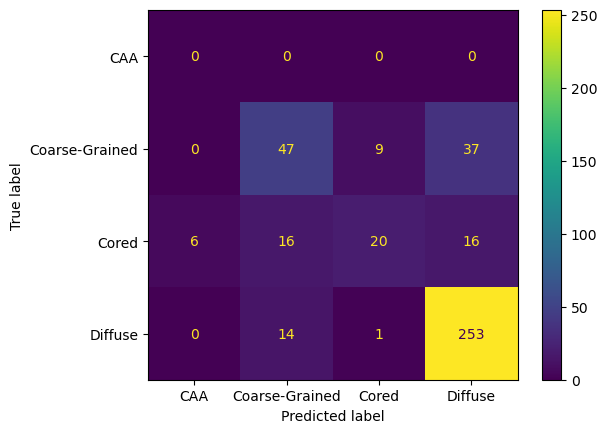

In [100]:
#for rater in raters:
#df_max= df[(~df["object_names"].isna())]
#if len(df_max)>0:
#print("Rater", rater)
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))
    #break

In [273]:
consensus_objects =  all_raters_combined[all_raters_combined["consensus"]>=2]

In [274]:
df

,pred_labels,actual_label,rater_name,object_names,img_name,flag,actual_label1
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs,0,Coarse-Grained
2,Diffuse,Diffuse,Max,9:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
3,Diffuse,Diffuse,Harry,30:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
4,Diffuse,Diffuse,Harry,28:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
...,...,...,...,...,...,...,...
282,Diffuse,Diffuse,Brittany,35:Diffuse,354049_6_AmyB_1_ceren.mrxs,1,Diffuse
283,Diffuse,Diffuse,Brittany,02:Diffuse,354049_6_AmyB_1_ceren.mrxs,0,Diffuse
284,Diffuse,Diffuse,Brittany,16:Diffuse,354049_6_AmyB_1_ceren.mrxs,0,Diffuse
285,Diffuse,Diffuse,Brittany,08:Diffuse,354049_6_AmyB_1_ceren.mrxs,1,Diffuse


In [275]:
consensus_objects

,main_rater_class,main_rater_object_name,rater1_class,rater1_object_name,geojson_file,rater2_class,rater2_object_name,consensus
1,Cored,0:Cored,Cored,01:Cored,22650_7_AmyB_1_ceren.mrxs.geojson,Cored,01:Cored,3
3,Coarse-Grained,3:Coarse-Grained,Diffuse,03:Diffuse,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,02:Coarse-Grained,2
4,Coarse-Grained,8:Coarse-Grained,Coarse-Grained,11:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,22:Coarse-Grained,3
5,Coarse-Grained,12:Coarse-Grained,Coarse-Grained,12:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,23:Coarse-Grained,3
7,Coarse-Grained,14:Coarse-Grained,Coarse-Grained,07:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,20:Coarse-Grained,3
...,...,...,...,...,...,...,...,...
3224,Diffuse,29:Diffuse,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,52:Diffuse,2
3226,Diffuse,16:Diffuse,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,07:Diffuse,2
3227,Coarse-Grained,4:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,33:Coarse-Grained,2
3228,Coarse-Grained,5:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,17:Coarse-Grained,2


In [276]:
df.head(2)

,pred_labels,actual_label,rater_name,object_names,img_name,flag,actual_label1
0,Diffuse,Diffuse,Max,5:Diffuse,420418_6_AmyB_1_ceren.mrxs,0,Diffuse
1,Diffuse,Coarse-Grained,Max,6:Coarse-Grained,420418_6_AmyB_1_ceren.mrxs,0,Coarse-Grained


In [277]:
df["flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max" and l["object_names"] in consensus_objects["main_rater_object_name"].values) or  
                      (l["rater_name"]=="Brittany" and l["object_names"] in consensus_objects["rater1_object_name"].values)
                      or  (l["rater_name"]=="Harry" and l["object_names"] in consensus_objects["rater2_object_name"].values) else 0, axis=1)

In [278]:
df_common["pred_labels"].unique()

array(['Diffuse', 'Cored', 'Coarse-Grained', 'CAA'], dtype=object)

In [279]:
df_common["actual_label"].unique()

array(['Diffuse', 'Cored', 'Coarse-Grained'], dtype=object)

In [280]:
df["actual_label1"] =  np.where(df["actual_label"]=="Neuritic","Coarse-Grained",df["actual_label"])

[[  0   0   0   0]
 [  0  26   6  27]
 [  4  13  15  14]
 [  0   8   0 145]]
[0.         0.55319149 0.71428571 0.77956989] [0.         0.44067797 0.32608696 0.94771242] [0.         0.49056604 0.44776119 0.85545723] [  0  59  46 153]
0.7209302325581395


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


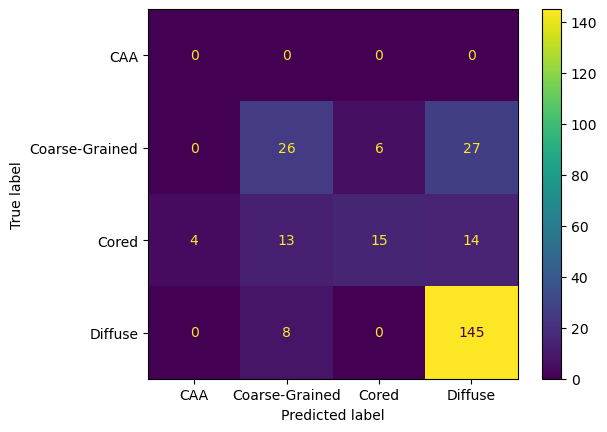

In [281]:
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label1"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])

precision, recall, fscore, support = precision_recall_fscore_support(df_common["actual_label1"],df_common["pred_labels"])
print(precision, recall, fscore, support)
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))

In [196]:
consensus_objects =  all_raters_combined[all_raters_combined["consensus"]>=3]

In [197]:
df["flag"] = df.apply(lambda l: 1 if (l["rater_name"]=="Max" and l["object_names"] in consensus_objects["main_rater_object_name"].values) or  
                      (l["rater_name"]=="Brittany" and l["object_names"] in consensus_objects["rater1_object_name"].values)
                      or  (l["rater_name"]=="Harry" and l["object_names"] in consensus_objects["rater2_object_name"].values) else 0, axis=1)

[[ 0  0  0  0]
 [ 0 14  4  7]
 [ 4  6 10 10]
 [ 0  1  0 86]]
[0.         0.66666667 0.71428571 0.83495146] [0.         0.56       0.33333333 0.98850575] [0.         0.60869565 0.45454545 0.90526316] [ 0 25 30 87]
0.7746478873239436


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


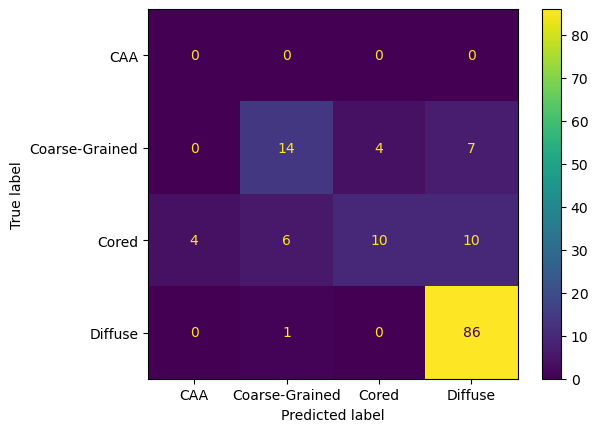

In [198]:
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])

precision, recall, fscore, support = precision_recall_fscore_support(df_common["actual_label"],df_common["pred_labels"])
print(precision, recall, fscore, support)
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))

[[  0   0   0   0]
 [  0  47   9  37]
 [  6  16  20  16]
 [  0  14   1 253]]
[0.         0.61038961 0.66666667 0.82679739] [0.         0.50537634 0.34482759 0.94402985] [0.         0.55294118 0.45454545 0.8815331 ] [  0  93  58 268]
0.7637231503579952


/home/mahirwar/miniconda3/envs/kfold_amy_plaque1/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


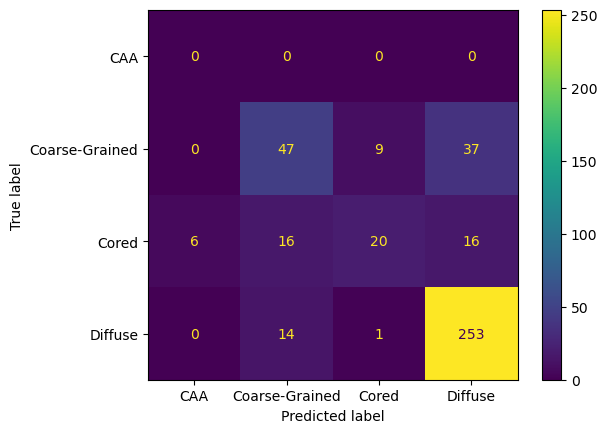

In [101]:
df_common = df[df["flag"]==1]
conf_mat = confusion_matrix(df_common["actual_label"],df_common["pred_labels"] )
print(conf_mat)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                            display_labels=[ 'CAA','Coarse-Grained', 'Cored','Diffuse'])

precision, recall, fscore, support = precision_recall_fscore_support(df_common["actual_label"],df_common["pred_labels"])
print(precision, recall, fscore, support)
disp.plot()
print(np.trace(conf_mat)/np.sum(conf_mat))

In [199]:
all_raters_combined.columns

Index(['main_rater_class', 'main_rater_object_name', 'rater1_class',
       'rater1_object_name', 'geojson_file', 'rater2_class',
       'rater2_object_name', 'consensus'],
      dtype='object')

In [282]:
table = all_raters_combined[["main_rater_class","rater1_class","rater2_class"]]

In [233]:
all_raters_combined["geojson_file"].unique()

array(['22650_7_AmyB_1_ceren.mrxs.geojson',
       '25144_1_AmyB_1_ceren.mrxs.geojson',
       '22640_1_AmyB_1_ceren.mrxs.geojson',
       '30414_6_AmyB_1_ceren.mrxs.geojson',
       '420418_6_AmyB_1_ceren.mrxs.geojson',
       '354049_6_AmyB_1_ceren.mrxs.geojson'], dtype=object)

In [237]:
for i in all_raters_combined["geojson_file"].unique():  
    print(i, len(all_raters_combined[all_raters_combined["geojson_file"] == i]))
    

22650_7_AmyB_1_ceren.mrxs.geojson 15
25144_1_AmyB_1_ceren.mrxs.geojson 29
22640_1_AmyB_1_ceren.mrxs.geojson 49
30414_6_AmyB_1_ceren.mrxs.geojson 298
420418_6_AmyB_1_ceren.mrxs.geojson 49
354049_6_AmyB_1_ceren.mrxs.geojson 2791


In [238]:
all_raters_combined[all_raters_combined["geojson_file"] == "354049_6_AmyB_1_ceren.mrxs.geojson"]

,main_rater_class,main_rater_object_name,rater1_class,rater1_object_name,geojson_file,rater2_class,rater2_object_name,consensus
440,None,NaN,Diffuse,19:Diffuse,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,45:Diffuse,2
441,None,NaN,Diffuse,19:Diffuse,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,44:Coarse-Grained,1
442,None,NaN,Diffuse,19:Diffuse,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,73:Diffuse,2
443,None,NaN,Diffuse,19:Diffuse,354049_6_AmyB_1_ceren.mrxs.geojson,Cored,42:Cored,1
444,None,NaN,Diffuse,19:Diffuse,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,72:Coarse-Grained,1
...,...,...,...,...,...,...,...,...
3226,Diffuse,16:Diffuse,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,07:Diffuse,2
3227,Coarse-Grained,4:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,33:Coarse-Grained,2
3228,Coarse-Grained,5:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,17:Coarse-Grained,2
3229,Coarse-Grained,0:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,31:Coarse-Grained,2


In [236]:
all_raters_combined[all_raters_combined["geojson_file"] == "22640_1_AmyB_1_ceren.mrxs.geojson"]

,main_rater_class,main_rater_object_name,rater1_class,rater1_object_name,geojson_file,rater2_class,rater2_object_name,consensus
44,Cored,13:Cored,Cored,03:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,19:Cored,3
45,Cored,16:Cored,Cored,04:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,24:Cored,3
46,Cored,17:Cored,Coarse-Grained,05:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,25:Coarse-Grained,2
47,Cored,32:Cored,Cored,01:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,23:Coarse-Grained,2
48,Coarse-Grained,20:Coarse-Grained,Cored,07:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,26:Coarse-Grained,2
49,Cored,33:Cored,Cored,02:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,22:Cored,3
50,Cored,34:Cored,Coarse-Grained,18:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,21:Cored,2
51,Cored,19:Cored,Coarse-Grained,06:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,20:Cored,2
52,Coarse-Grained,8:Coarse-Grained,Coarse-Grained,14:Coarse-Grained,22640_1_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,05:Coarse-Grained,3
53,Cored,3:Cored,Cored,10:Cored,22640_1_AmyB_1_ceren.mrxs.geojson,Cored,02:Cored,3


In [ ]:
all_raters_combined[all_raters_combined["geojson_file"] == "22640_1_AmyB_1_ceren.mrxs.geojson"]

In [307]:
all_raters_combined

,main_rater_class,main_rater_object_name,rater1_class,rater1_object_name,geojson_file,rater2_class,rater2_object_name,consensus
0,Cored,2:Cored,Diffuse,04:Diffuse,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,04:Neuritic,1
1,Cored,0:Cored,Cored,01:Cored,22650_7_AmyB_1_ceren.mrxs.geojson,Cored,01:Cored,3
2,Coarse-Grained,1:Coarse-Grained,Diffuse,02:Diffuse,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,03:Neuritic,1
3,Coarse-Grained,3:Coarse-Grained,Diffuse,03:Diffuse,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,02:Coarse-Grained,2
4,Coarse-Grained,8:Coarse-Grained,Coarse-Grained,11:Coarse-Grained,22650_7_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,22:Coarse-Grained,3
...,...,...,...,...,...,...,...,...
3226,Diffuse,16:Diffuse,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Diffuse,07:Diffuse,2
3227,Coarse-Grained,4:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,33:Coarse-Grained,2
3228,Coarse-Grained,5:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,17:Coarse-Grained,2
3229,Coarse-Grained,0:Coarse-Grained,None,NaN,354049_6_AmyB_1_ceren.mrxs.geojson,Coarse-Grained,31:Coarse-Grained,2


In [293]:
common = all_raters_combined[(all_raters_combined["rater1_class"]!="None") & (all_raters_combined["rater2_class"]!="None")]

In [308]:
table = all_raters_combined[["main_rater_class","rater1_class","rater2_class"]]

In [309]:
dict1 = {"Coarse-Grained":1, "Diffuse":2, "Cored":3, "None":4,"Neuritic":5}

In [310]:
table= table.fillna("None")

In [311]:
table["main_rater_class"]=table["main_rater_class"].apply(lambda l: dict1[l])
table["rater1_class"]=table["rater1_class"].apply(lambda l:  dict1[l])
table["rater2_class"]=table["rater2_class"].apply(lambda l:  dict1[l])

In [312]:
table

,main_rater_class,rater1_class,rater2_class
0,3,2,1
1,3,3,3
2,1,2,1
3,1,2,1
4,1,1,1
...,...,...,...
3226,2,4,2
3227,1,4,1
3228,1,4,1
3229,1,4,1


In [313]:
def fleiss_kappa1(lists, classes):
    n = len(lists)
    N = len(lists[0])
    k = len(classes)
    
    nij = []
    for i in range(N):
        nij.append([0]*k)
        
    
    for i in range(len(lists)):
        for j in range(len(lists[i])):
            nij[j][classes.index(lists[i][j])] += 1 
    
    P = []
    for i in nij:
        P.append(1/(n*(n-1))*(sum([j*j for j in i])-n))
    return (((sum(P)/N)-(sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]])))/(1-sum([y*y for y in [x/(N*n) for x in[sum(i) for i in zip(*nij)]]]))+1)/2

In [314]:
rater1 = table["main_rater_class"].values
rater2 = table["rater1_class"].values
rater3 = table["rater2_class"].values

In [315]:
lists = [rater1, rater2, rater3]
kappa = fleiss_kappa1(lists,[1,2,3,4])

In [316]:
kappa

0.6386687797147383

In [320]:
for class_type in table["main_rater_class"].unique():
    rater2 = table[table["main_rater_class"]==class_type]["rater1_class"].values
    rater3 = table[table["main_rater_class"]==class_type]["rater2_class"].values
    lists = [rater2, rater3]
    kappa = fleiss_kappa1(lists,[1,2,3,4])
    print(class_type,kappa)
    

3 0.6292455276121338
1 0.5126050420168068
2 0.48796722990271374


Rater Max
[[ 0  0  0  0]
 [ 0 15  2 23]
 [ 1  8  7  9]
 [ 0  0  0 55]]
0.6416666666666667
Rater Harry
[[ 0  0  0  0]
 [ 0 12  2  9]
 [ 1  2  4  3]
 [ 0  0  0 44]]
0.7792207792207793
Rater Brittany
[[ 0  0  0  0]
 [ 0  8  3  2]
 [ 2  4  5  3]
 [ 0  8  0 55]]
0.7555555555555555


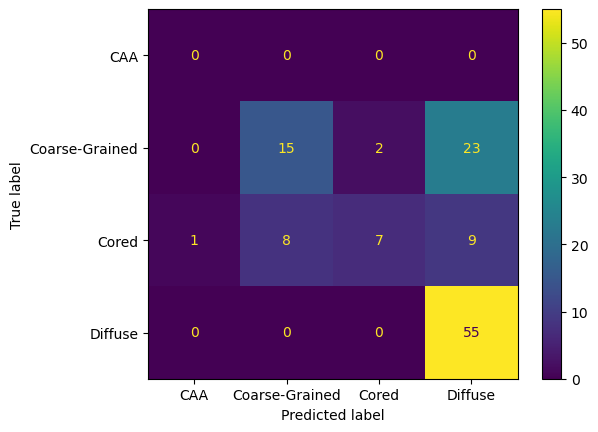

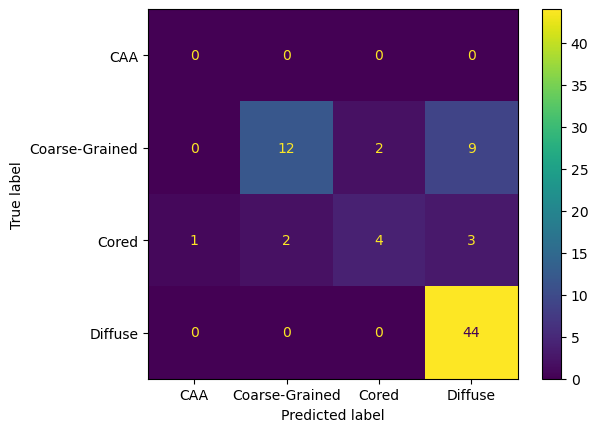

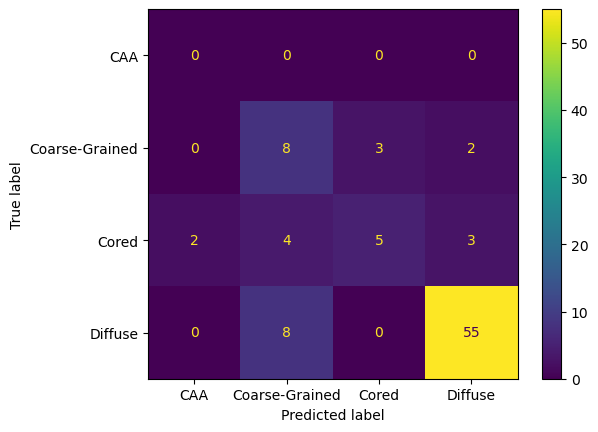

In [318]:
for rater in raters:
    df_max= df[(df["rater_name"]==rater) ]
    #if len(df_max)>0:
    print("Rater", rater)
    conf_mat = confusion_matrix(df_max["actual_label1"],df_max["pred_labels"])
    print(conf_mat)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=['CAA','Coarse-Grained','Cored', 'Diffuse'])
    disp.plot()
    print(np.trace(conf_mat)/np.sum(conf_mat))
